# MS019 Preprocess
Created: 01/25/2024 \
Updated: 05/10/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
from ast import literal_eval



import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS019'
subj_format = ['edf']
subj_site = ['MSSM']


In [39]:
#### print date of last run
date = datetime.date.today().strftime('%m%d%Y')
print(date)

05102024


# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/raw/MS019_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2175999  =      0.000 ...  2124.999 secs...


In [7]:
mne_data

<RawEDF | MS019_SWB.edf, 276 x 2176000 (2125.0 s), ~4.47 GB, data loaded>

In [8]:
# mne_data.ch_names

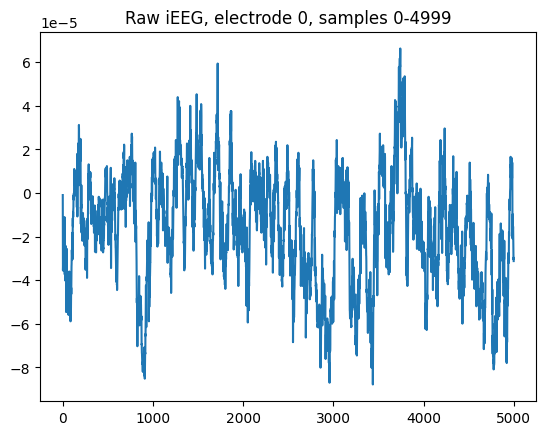

In [8]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [9]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:  2.2min finished


<RawEDF | MS019_SWB.edf, 276 x 1062500 (2125.0 s), ~2.19 GB, data loaded>

### Notch filter line noise

In [12]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:    9.2s finished


<RawEDF | MS019_SWB.edf, 275 x 1062500 (2125.0 s), ~2.18 GB, data loaded>

### Photodiode
- examine photodiode 

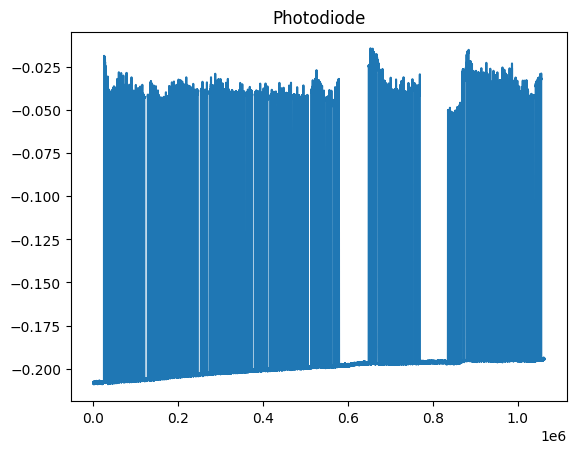

In [12]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [13]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/photodiode.fif
[done]


In [14]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS019_SWB.edf, 275 x 1062500 (2125.0 s), ~2.18 GB, data loaded>

### Anatomical Localization

In [15]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS019_SWB.edf, 275 x 1062500 (2125.0 s), ~2.18 GB, data loaded>

In [16]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCaS1,A32sg_L,-2.795636,34.346371,5.999996,-2.570422,27.802347,-5.413951,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus C,NaN,NaN
1,LaCaS10,A9l_L,-11.581916,56.312073,43.999994,-12.306464,60.493542,33.029109,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 1 D,NaN,NaN
2,LaCaS11,Unknown,-12.380669,59.107707,48.399994,-13.320612,64.809729,37.490489,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
3,LaCaS12,Unknown,-13.179422,60.305837,51.199993,-14.276922,66.898697,40.415833,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
4,LaCaS2,A32sg_L,-3.594388,36.742630,9.999996,-3.429509,31.395072,-1.489375,Gray,Left ACgG anterior cingulate gyrus,Area 33,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,RsPpC7,A7ip_R,25.160712,-45.129531,35.999994,26.390526,-50.717179,46.775628,Gray,Right SPL superior parietal lobule,Unknown,Unknown,R SPL,Right superior parietal 2 D,WM,NaN
168,RsPpC8,A7ip_R,28.755099,-47.525789,39.199994,30.549717,-52.507090,50.966902,Gray,Right SPL superior parietal lobule,Area hIP3 (IPS),R Inferior Parietal Lobule,R SPL,Right superior parietal 2 D,NaN,NaN
169,RsPpC9,A7ip_R,32.349487,-49.522671,41.999994,34.673166,-54.045856,54.610691,Gray,Right SPL superior parietal lobule,Area hIP3 (IPS),R Inferior Parietal Lobule,R SPL,Right superior parietal 2 D,NaN,NaN
170,uLmOIF,A13_L,-4.792518,37.940759,-4.800003,-4.177642,28.423886,-18.311256,Gray,Left MFC medial frontal cortex,Area s32,L Rectal Gyrus,L OrG,Left frontal pole 1 B,NaN,NaN


In [17]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAgIT1',
 'LAgIT10',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LHpIT1',
 'LHpIT10',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',
 'LHpIT9',
 'LiITO1',
 'LiITO2',
 'LiITO3',
 'LiITO4',
 'LiITO5',
 'LiITO6',
 'LiITO7',
 'LiITO8',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOIF1',
 'LmOIF2',
 'LmOIF3',
 'LmOIF4',
 'LmOIF5',
 'LmOIF6',
 'LmOIF7',
 'LmOIF8',
 'LmOIF9',
 'LpIOC1',
 'LpIOC10',
 'LpIOC11',
 'LpIOC12',
 'LpIOC13',
 'LpIOC14',
 'LpIOC2',
 'LpIOC3',
 'LpIOC4',
 'LpIOC5',
 'LpIOC6',
 'LpIOC7',
 'LpIOC8',
 'LpIOC9',
 'LsPpC1',
 'LsPpC10',
 'LsPpC11',
 'LsPpC12',
 'LsPpC2',
 'LsPpC3',
 'LsPpC4',
 'LsPpC5',
 'LsPpC6',
 'LsPpC7',
 'LsPpC8',
 'LsPpC9',
 'RaCaS1',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'Ra

In [18]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lmolf1', 'lmolf2', 'lmolf3', 'lmolf4', 'lmolf5', 'lmolf6', 'lmolf7', 'lmolf8', 'lmolf9', 'rmolf1', 'rmolf2', 'rmolf3', 'rmolf4', 'rmolf5', 'rmolf6', 'rmolf7', 'rmolf8', 'rmolf9', 'c63', 'c64', 'lilto1', 'lilto2', 'lilto3', 'lilto4', 'lilto5', 'lilto6', 'lilto7', 'lilto8', 'rilto1', 'rilto2', 'rilto3', 'rilto4', 'rilto5', 'rilto6', 'rilto7', 'rilto8', 'laglt1', 'laglt2', 'laglt3', 'laglt4', 'laglt5', 'laglt6', 'laglt7', 'laglt8', 'laglt9', 'laglt10', 'raglt1', 'raglt2', 'raglt3', 'raglt4', 'raglt5', 'raglt6', 'raglt7', 'raglt8', 'raglt9', 'raglt10', 'c125', 'c126', 'c127', 'c128', 'lhplt1', 'lhplt2', 'lhplt3', 'lhplt4', 'lhplt5', 'lhplt6', 'lhplt7', 'lhplt8', 'lhplt9', 'lhplt10', 'rhplt1', 'rhplt2', 'rhplt3', 'rhplt4', 'rhplt5', 'rhplt6', 'rhplt7', 'rhplt8', 'rhplt9', 'rhplt10', 'lploc1', 'lploc2', 'lploc3', 'lploc4', 'lploc5', 'lploc6', 'lploc7', 'lploc8', 'lploc9', 'lploc10', 'lploc11', 'lploc12', 'lploc13', 'lploc14', 'rploc1', 'rploc2', 'rploc3', 'rploc4', 'rploc5', 'rploc6', 'rpl

In [19]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [20]:
unmatched_seeg #make sure there are no unmatched names


[]

In [21]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [22]:
new_name_dict #make sure this passes the eye test 


{'lmolf1': 'lmoif1',
 'lmolf2': 'lmoif2',
 'lmolf3': 'lmoif3',
 'lmolf4': 'lmoif4',
 'lmolf5': 'lmoif5',
 'lmolf6': 'lmoif6',
 'lmolf7': 'lmoif7',
 'lmolf8': 'lmoif8',
 'lmolf9': 'lmoif9',
 'rmolf1': 'rmoif1',
 'rmolf2': 'rmoif2',
 'rmolf3': 'rmoif3',
 'rmolf4': 'rmoif4',
 'rmolf5': 'rmoif5',
 'rmolf6': 'rmoif6',
 'rmolf7': 'rmoif7',
 'rmolf8': 'rmoif8',
 'rmolf9': 'rmoif9',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'lacas11': 'lacas11',
 'lacas12': 'lacas12',
 'racas1': 'racas1',
 'racas2': 'racas2',
 'racas3': 'racas3',
 'racas4': 'racas4',
 'racas5': 'racas5',
 'racas6': 'racas6',
 'racas7': 'racas7',
 'racas8': 'racas8',
 'racas9': 'racas9',
 'racas10': 'racas10',
 'racas11': 'racas11',
 'racas12': 'racas12',
 'lmcms1': 'lmcms1',
 'lmcms2': 'lmcms2',
 'lmcms3': 'lmcms3',
 'lmcms4': 'lmcms4',
 'lmcms5': 'lmcms5',
 

In [23]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS019_SWB.edf, 275 x 1062500 (2125.0 s), ~2.18 GB, data loaded>

In [24]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 85 left sEEG and 85 right sEEG electrodes
We have a total of 170 sEEG electrodes


In [25]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS019_SWB.edf, 275 x 1062500 (2125.0 s), ~2.18 GB, data loaded>

In [26]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS019_SWB.edf, 170 x 1062500 (2125.0 s), ~1.35 GB, data loaded>

In [27]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS019_SWB.edf, 170 x 1062500 (2125.0 s), ~1.35 GB, data loaded>

In [28]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [29]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [30]:
probe_ch_counts

{'lacas': 12,
 'lagit': 10,
 'lhpit': 10,
 'liito': 8,
 'lmcms': 10,
 'lmoif': 9,
 'lpioc': 14,
 'lsppc': 12,
 'racas': 12,
 'ragit': 10,
 'rhpit': 10,
 'riito': 8,
 'rmcms': 10,
 'rmoif': 9,
 'rpioc': 14,
 'rsppc': 12,
 'ulmoif': 1,
 'urmoif': 1}

## ~DEPRECIATED - Signal Cleaning Before Re-Ref~

~- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary~ \
~- This process is iterative depending on how TFRs look.~

In [10]:
# # mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
# lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

In [11]:
#  %matplotlib notebook
# fig = mne_data.plot(start=0, duration=1000, n_channels=40, scalings=mne_data._data.max()/50)


In [26]:
# mne_data.info['bads'] = ['lsppc11',
#  'rsppc12',
#  'ragit9',
#  'rhpit1',
#  'rhpit2',
#  'rhpit3',
#  'lhpit1',
#  'lhpit2']

## Save mne_data
NO CHANNEL REMOVAL BEFORE RE-REFERENCING \
**PIPELINE CHANGE IMPLEMENTED 05/09/2024**

In [31]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/raw_ieeg.fif
[done]


# Re-referencing + Signal Cleaning
1. bipolar rereference raw ieeg data 
2. plot lfp + psd for bp data
3. remove bad bp reref channels
4. localize roi for reref channels
5. save bp reref data & localization info


In [32]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [33]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=67, n_times=1062500
    Range : 0 ... 1062499 =      0.000 ...  2124.998 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas3-lacas4, lacas4-lacas5, lacas5-lacas6, lacas6-lacas7, lacas7-lacas8, lacas8-lacas9, lacas9-lacas10, lagit1-lagit2, lagit2-lagit3, lagit3-lagit4, lagit6-lagit7, lagit7-lagit8, lagit8-lagit9, lhpit1-lhpit2, lhpit2-lhpit3, lhpit8-lhpit9, liito5-liito6, lmcms1-lmcms2, lmcms2-lmcms3, lmcms3-lmcms4, lmcms4-lmcms5, lmcms5-lmcms6, lmcms6-lmcms7, lmoif2-lmoif3, lmoif3-lmoif4, lmoif4-lmoif5, lmoif5-lmoif6, lmoif6-lmoif7, lmoif7-lmoif8, lmoif8-lmoif9, lpioc12-lpioc13, lsppc1-lsppc2, lsppc2-lsppc3, lsppc3-lsppc4, lsppc9-lsppc10, racas5-racas6, racas6-racas7, racas8-racas9, racas9-racas10, ragit1-ragit2, ragit2-ragit3, ragit3-ragit4, ragit5-ragit6, rag

In [34]:
mne_data_bp_reref

<RawEDF | MS019_SWB.edf, 67 x 1062500 (2125.0 s), ~543.3 MB, data loaded>

In [35]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas3-lacas4',
 'lacas4-lacas5',
 'lacas5-lacas6',
 'lacas6-lacas7',
 'lacas7-lacas8',
 'lacas8-lacas9',
 'lacas9-lacas10',
 'lagit1-lagit2',
 'lagit2-lagit3',
 'lagit3-lagit4',
 'lagit6-lagit7',
 'lagit7-lagit8',
 'lagit8-lagit9',
 'lhpit1-lhpit2',
 'lhpit2-lhpit3',
 'lhpit8-lhpit9',
 'liito5-liito6',
 'lmcms1-lmcms2',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmcms4-lmcms5',
 'lmcms5-lmcms6',
 'lmcms6-lmcms7',
 'lmoif2-lmoif3',
 'lmoif3-lmoif4',
 'lmoif4-lmoif5',
 'lmoif5-lmoif6',
 'lmoif6-lmoif7',
 'lmoif7-lmoif8',
 'lmoif8-lmoif9',
 'lpioc12-lpioc13',
 'lsppc1-lsppc2',
 'lsppc2-lsppc3',
 'lsppc3-lsppc4',
 'lsppc9-lsppc10',
 'racas5-racas6',
 'racas6-racas7',
 'racas8-racas9',
 'racas9-racas10',
 'ragit1-ragit2',
 'ragit2-ragit3',
 'ragit3-ragit4',
 'ragit5-ragit6',
 'ragit6-ragit7',
 'ragit7-ragit8',
 'rhpit1-rhpit2',
 'rhpit2-rhpit3',
 'rhpit5-rhpit6',
 'rhpit6-rhpit7',
 'rhpit7-rhpit8',
 'riito5-riito6',
 'rmcms1-rmcms2',
 'rmcms2-rmcms3',
 'rmc

# Manual Signal Cleaning 
Methods:
- Use manual bad channel removal for **bipolar** re referenced data 
- This process is iterative depending on how TFRs look. 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


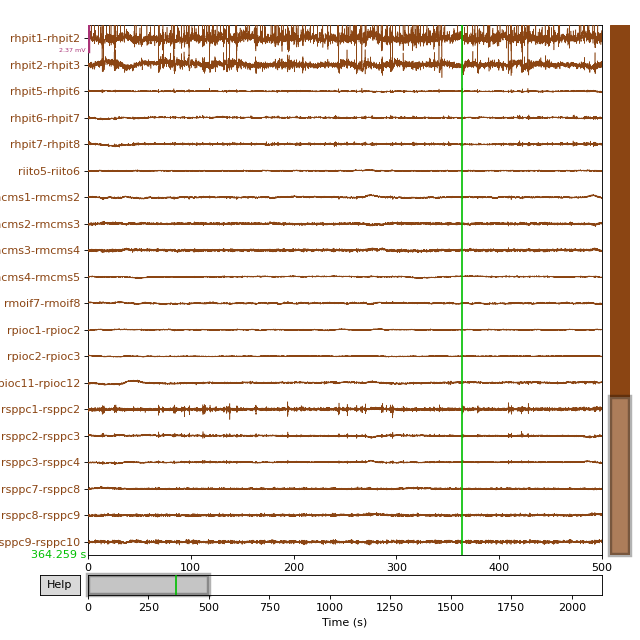

In [36]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=500, n_channels=20, scalings=mne_data_bp_reref._data.max()/5)

Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


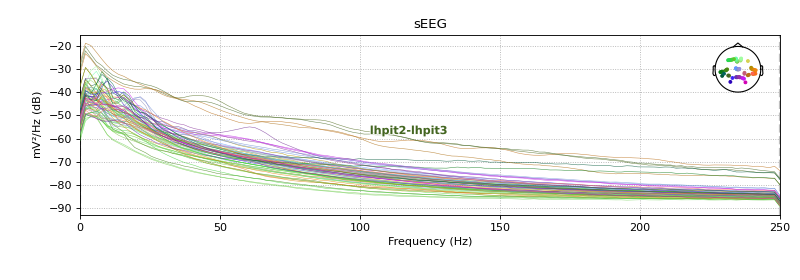

<IPython.core.display.Javascript object>


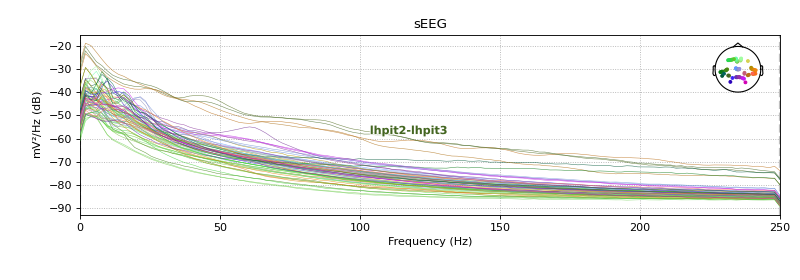

In [37]:
mne_data_bp_reref.compute_psd().plot()

In [40]:
print(mne_data_bp_reref.info['bads'],date)

[] 05102024


## Save Reref Data

In [41]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/bp_ref_ieeg.fif
[done]


In [35]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

# Photodiode Alignment
SWB photodiodes should be aligned to TrialOnset
- extract TrialOnset times to align to photodiode deflection onset 
- clean photodiode data if necessary (if photodiode is inverted, noisy etc)
- align photodiode (if function fails, try manual alignment)
- verify proper alignment by plotting

In [42]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 


In [43]:
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/photodiode.fif...
Isotrak not found
    Range : 0 ... 1062499 =      0.000 ...  2124.998 secs
Ready.
Reading 0 ... 1062499  =      0.000 ...  2124.998 secs...


In [44]:
photodiode_data

<Raw | photodiode.fif, 1 x 1062500 (2125.0 s), ~8.1 MB, data loaded>

<IPython.core.display.Javascript object>


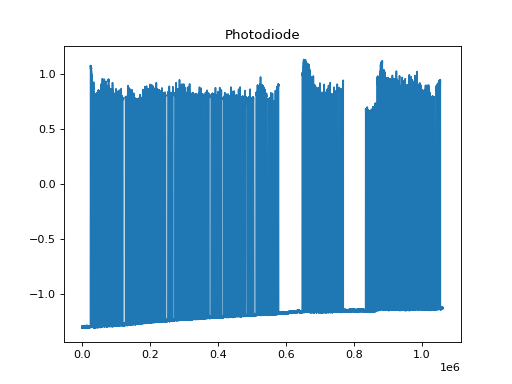

In [47]:
# Sanity check the photodiode
# plt.plot(photodiode_data._data[0,:])
plt.plot(zscore(photodiode_data._data[0,:]))
plt.title("Photodiode")
plt.show()

In [114]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.74

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, #
                                            smoothSize, windSize, height)

17 blocks
.................

found matches for 120 of 257 pulses
12 blocks
............

found matches for 60 of 257 pulses


In [116]:
print(slope, offset,smoothSize,windSize,height)

0.9999994763087914 -54.75708697473186 11 15 0.74


In [117]:
# print(slope, offset,smoothSize,windSize,height)
# 1.0000011394611152 -54.75852568620667 11 15 0.75
# 1.0000040317364238 -54.77448258039476 11 15 0



In [118]:
# calculate pulse times from slope + offset
pulses = [(x*slope + offset) for x in beh_ts]
len(pulses) 

150

In [119]:
##### validate by plotting!
photo_sfreq = photodiode_data.info['sfreq']
photo_sfreq


500.0

<IPython.core.display.Javascript object>


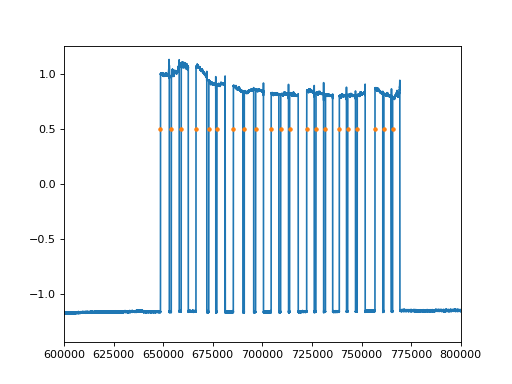

In [124]:
plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
# plt.plot(pulses)
plt.plot(np.array(pulses)*photo_sfreq, 
         np.ones_like(np.array(pulses)*photo_sfreq)-0.5, '.')
# plt.plot(neural_ts*1024, 
#          np.ones_like(neural_ts)-0.25, '.')
# plt.xlim([400000,500000]) ### shows misc data pt 
plt.xlim([600000,800000]) ### shows misc data pt 
plt.show()

# Epoch Data
- Epoch neural data into trial epochs (and save df with IEDs/artifacts for every ev)
- Save epochs
- Baseline + decompose data into TFRs
- Add behavioral data to epochs metadata
- Plot + save TFRs (examine quality)

Note: Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated


In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

### Get behavior ts for epochs of interest
- time points in SWB code are nonsensical - choice onset is a repeat of trial onset, and the difference between choice onset and decision onset is just the RT.
- even worse, feedback onset does not accurately mark feedback for safe choice trials - the feedback time is the safe outcome reveal, NOT counterfactual feedback. There is no true counterfactual feedback timestamp that's accurate for every trial. 
- Solution - make a new timestamp vector that is +2 seconds after DecisionOnset to use for counterfactual outcome feedback epochs


MAJOR UPDATE 05/09/2024 FROM PIPELINE UPDATE

In [125]:
#### load behavior data and define baseline/analysis epoch timepoints 

#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,util_dCPE_emmap,util_tCF_emmap,util_dCF_emmap,util_tRegret_emmap,util_dRegret_emmap,util_tRelief_emmap,util_dRelief_emmap,util_RPE_emmap,util_pRPE_emmap,util_nRPE_emmap
0,1,46.0,mix,166.906253,166.919553,169.226881,171.243757,2.307328,0.0,-1.10,...,0.872387,-0.023004,0.000000,0.000000,0.000000,0.895391,0.872387,0.023004,0.023004,0.000000
1,2,101.0,loss,175.808985,175.817546,180.104779,182.121601,4.287233,-0.2,-0.34,...,0.000679,0.000000,-0.006917,-0.006238,0.000679,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,140.0,loss,187.642181,187.643002,190.399471,192.415833,2.756468,-0.5,-2.50,...,-0.038143,0.000000,-0.019153,-0.057296,-0.038143,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,35.0,mix,204.841573,204.849139,207.922985,209.939695,3.073846,0.0,-0.30,...,0.160616,-0.005428,0.000000,0.000000,0.000000,0.166044,0.160616,0.005428,0.005428,0.000000
4,5,114.0,loss,214.696737,214.704561,219.116613,219.122804,4.412052,-0.3,-0.67,...,-0.010855,0.000000,0.000000,-0.010855,-0.010855,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,143.0,loss,2112.435856,2112.436581,2114.579035,2116.595655,2.142454,-0.6,-1.20,...,0.023455,-0.025340,-0.023455,0.000000,0.000000,0.025340,0.023455,0.025340,0.025340,0.000000
146,147,95.0,gain,2121.587093,2121.595276,2123.574190,2125.590179,1.978914,0.6,0.00,...,-0.566773,0.778881,0.566773,-0.778881,-0.566773,0.000000,0.000000,-0.778881,0.000000,-0.778881
147,148,70.0,gain,2138.749941,2138.756112,2141.098827,2143.115514,2.342715,0.3,0.00,...,-0.262305,0.784693,0.262305,-0.784693,-0.262305,0.000000,0.000000,-0.784693,0.000000,-0.784693
148,149,97.0,gain,2147.662038,2147.667898,2150.010739,2152.027454,2.342841,0.6,0.00,...,-0.566773,1.020497,0.566773,-1.020497,-0.566773,0.000000,0.000000,-1.020497,0.000000,-1.020497


In [126]:
list(zip(behav_df.GambleChoice,behav_df.DecisionOnset,behav_df.FeedbackOnset))

[('gamble', 169.22688059997745, 171.24375659998623),
 ('gamble', 180.10477889998583, 182.12160089999088),
 ('gamble', 190.3994707999809, 192.4158334999811),
 ('gamble', 207.92298509998363, 209.9396952999814),
 ('safe', 219.1166130999918, 219.12280399998417),
 ('gamble', 228.8621073999966, 230.8792467000021),
 ('gamble', 239.72352639999008, 241.7396819999849),
 ('gamble', 249.2848449999874, 251.30177259998163),
 ('gamble', 259.99589699998614, 262.0121689999942),
 ('gamble', 270.3232225999818, 272.3401500999753),
 ('gamble', 279.7853274999943, 281.80179559998214),
 ('gamble', 289.4130966999801, 291.4287700999994),
 ('gamble', 314.1499466999958, 316.16626410000026),
 ('gamble', 323.64545969999745, 325.66185179998865),
 ('gamble', 333.17373929999303, 335.18916919999174),
 ('gamble', 343.81810879998375, 345.834182599996),
 ('gamble', 353.41245699999854, 355.4288039999956),
 ('safe', 363.59175299998606, 363.5936149999907),
 ('gamble', 373.3185647999926, 375.33525559998816),
 ('gamble', 382.0

In [127]:
behav_df['CpeOnset'] = behav_df.DecisionOnset + 2.0
behav_df['CpeOnset']

0       171.226881
1       182.104779
2       192.399471
3       209.922985
4       221.116613
          ...     
145    2116.579035
146    2125.574190
147    2143.098827
148    2152.010739
149    2161.689020
Name: CpeOnset, Length: 150, dtype: float64

## SWB Epochs:

**Baseline epoch** = 1 sec prior to trial onset \
**Decision epoch** = 0.5 sec prior to decision onset (choice epoch) \
**Feedback epoch** = 3 sec after CPE reveal \

*Outputs: Raw epoched data & IED + artifact dfs for every epoch*


In [128]:
# Define epochs of interest according to timestamps from behavior df 

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [129]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [130]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [131]:
### make epochs should now find IEDs, artifact times, and save info as df in load_path directory for every ev

for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                                                 slope=slope, offset=offset,
                                                 behav_name=event, behav_times=behav_df[event].values,
                                                 ev_start_s=evs[event][0], ev_end_s=evs[event][1],
                                                 buf_s = 1, IED_args=IED_args,
                                                 downsamp_factor=None,  
                                                 detrend=0) #### new - constant detrend by DC offset https://mne.tools/stable/generated/mne.Epochs.html

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/bp_ref_ieeg.fif...
    Range : 0 ... 1062499 =      0.000 ...  2124.998 secs
Ready.
Reading 0 ... 1062499  =      0.000 ...  2124.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    5.4s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/bp_ref_ieeg.fif...
    Range : 0 ... 1062499 =      0.000 ...  2124.998 secs
Ready.
Reading 0 ... 1062499  =      0.000 ...  2124.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    5.4s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1251 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/bp_ref_ieeg.fif...
    Range : 0 ... 1062499 =      0.000 ...  2124.998 secs
Ready.
Reading 0 ... 1062499  =      0.000 ...  2124.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    5.4s finished


Used Annotations descriptions: ['CpeOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 2501 original time points ...
0 bad epochs dropped


In [132]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~115.2 MB, data loaded,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~96.1 MB, data loaded,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~191.9 MB, data loaded,
  'CpeOnset': 150>}

In [134]:
# to plot epochs if desired 
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')

### Add behavioral data to metadata

In [133]:
behav_params = ['Round','RT','CpeOnset','GambleChoice','TrialType',
                'SafeBet', 'LowBet', 'HighBet', 'GambleEV','Outcome',
                'Profit', 'TotalProfit', 'CR', 'choiceEV', 'RPE',
                'decisionCPE', 'decisionRegret','decisionRelief', 'decisionCF']

In [134]:
for event in evs.keys():

    event_metadata = pd.DataFrame(columns=behav_params)
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Adding metadata with 19 columns
Adding metadata with 19 columns
Adding metadata with 19 columns


### Save raw epoched data 

In [135]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/{event}_epochs.fif', overwrite=True)

In [136]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~115.2 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~96.1 MB, data loaded, with metadata,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~191.9 MB, data loaded, with metadata,
  'CpeOnset': 150>}

# Compute Baseline + Analysis TFRs
*Major updates 05/09/2024*
- Instead of removing entire epochs with IEDs, removing +/-100ms of IED or artifact timepoint 
- Now we have two analysis evs of interest - pre-decision epoch and cpe outcome epoch

In [137]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

baseline_ev  = 'TrialOnset' # fixation cross baseline epoch
analysis_evs = ['DecisionOnset','CpeOnset']

# dictionary of event ids and times - repeated from above
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [138]:
# Define spectrogram parameters for morlet wavelets 

freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


### Make Baseline TFR Epochs 

In [139]:
#### COMPUTE BASELINE TFRs 

# baseline epoch dictionary 
epochs_all_baseline = {} 

# baseline event = TrialOnset epochs 
baseline_epochs_reref = epochs_all_evs[baseline_ev]

# dropping bad channels from baseline epochs 
baseline_epochs_reref = baseline_epochs_reref.drop_channels(baseline_epochs_reref.info['bads'])

# compute baseline tfr 
temp_pow  = mne.time_frequency.tfr_morlet(baseline_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                          picks=baseline_epochs_reref.ch_names, # now doesn't include bad ch
                                          use_fft=True, n_jobs=-1, output='power',
                                          return_itc=False, average=False) # returns pow (not ITC) for all epochs

temp_pow.crop(tmin=evs[baseline_ev][0], tmax=evs[baseline_ev][1]) # clipping epoch to remove buffer

# Remove bad data by naning out +/-100ms around bad timepoints (IEDs and artifacts)
# THE following will now LOAD in dataframes that indicate IED and artifact time points in your data
IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_IED_df.csv') 
artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_artifact_df.csv') 

# iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
for ch_ix, ch_name in enumerate(baseline_epochs_reref.ch_names):
    # lists of IED/artifact timestamps from dfs for one channel (if any)
    ied_ev_list = IED_df[ch_name].dropna().index.tolist()
    artifact_ev_list = artifact_df[ch_name].dropna().index.tolist()
    
    # iterate through every IED timestamp in channel 
    for ev_ in ied_ev_list: 
        # iterate through values in IED df (literal eval = evaluates string as literal python data structures)
        for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((ied_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after 
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
    
    # iterate through every artifact timestamp in channel 
    for ev_ in artifact_ev_list: 
         # iterate through values in artifact df (literal eval = evaluates string as literal python data structures)
        for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

epochs_all_baseline[baseline_ev] = temp_pow


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   19.8s finished


Adding metadata with 19 columns


In [140]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 67, ~1.13 GB>}

### Compute Baseline-corrected TFRs for Analysis Epochs

In [141]:
#### COMPUTE ANALYSIS EVENT TFRs + BASELINE TO BASELINE TFRs 

# repeat baselining procedure for every event in analysis_evs
# remove +/-100ms around IED/artifact individually for each analysis epoch 
# baseline analysis ev tfrs
# iteratively check for zscores still above 10 std, remove those timepoints, then recompute baselined tfr


power_epochs = {} # keys = analysis evs 

for event in analysis_evs: 
    print('Compute baselined TFR for epoch: ',event)
    
    # extract raw epoch data for analysis ev 
    event_epochs_reref = epochs_all_evs[event].copy()
    # dropping bad channels from baseline epochs 
    event_epochs_reref = event_epochs_reref.drop_channels(event_epochs_reref.info['bads'])
    ch_names = event_epochs_reref.ch_names
    
    # compute TFR from raw epoched data
    temp_pow = mne.time_frequency.tfr_morlet(event_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                             picks=event_epochs_reref.ch_names, 
                                             use_fft=True, n_jobs=-1, output='power', 
                                             return_itc=False, average=False)
    # crop 1.0 sec buffer from analysis epoch 
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
    
    ### repeat IED/artifact removal procedure used for baseline epochs, but with analysis event IED/artifact times
    
    # load IED/artifact dfs specific to event in analysis evs
    IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_IED_df.csv') 
    artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_artifact_df.csv') 
    
    # iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
    for ch_ix, ch_name in enumerate(event_epochs_reref.ch_names): 
        ied_ev_list = IED_df[ch_name].dropna().index.tolist()
        artifact_ev_list = artifact_df[ch_name].dropna().index.tolist() 
        for ev_ in ied_ev_list: 
            for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((ied_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
        for ev_ in artifact_ev_list: 
            for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

    ##### remove extreme power values (z>10) remaining after IED/artifact removal 
    # iterative process - baseline correct event TFR, remove z > 10, re-baseline until no z>10 or reached max iters
    
                
    # Let's nan out absurd z-scores (10 std above baseline???) that escaped our artifact detection, noise removal, and baselining
    absurdity_threshold = 10 # zscore threshold for removal
    max_iter = 10 # max number of iterations for while loop 
    large_z_flag=True # flag that indicates whether large zs are present, when all z<10 = False in while loop

    iteration = 0 # intialize iter counter
    while (large_z_flag==True) & (iteration<max_iter): # while z>10 still in tfr or under max iter num 
        print(f'baseline z-score iteration # {iteration}')
        # Baseline by all the baseline periods in the session
        baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                              baseline_mne=epochs_all_baseline[baseline_ev].data,  
                              mode='zscore', ev_axis=0, elec_axis=1, freq_axis=2, time_axis=3)

        large_z_mask = np.where(baseline_corrected_power>absurdity_threshold)
        if large_z_mask[0].shape[0] == 0:
            # no more large z
            large_z_flag = False
        else:
            # NaN it out in the event of interest prior to re-running the baseline z-score to prevent
            # contamination of all z's
            temp_pow.data[large_z_mask] = np.nan

        iteration +=1
    
    # input baseline corrected pow into mne EpochsTFR object once all z>10 removed or iteratively removed 10x 
    zpow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, baseline_corrected_power,
                                        temp_pow.times, freqs)
    
    # add metadata to baseline corrected TFR event epochs object 
    zpow.metadata = event_epochs_reref.metadata
    
    # save data (#conda install -c conda-forge h5io must install to save tfr data)
    zpow.save(f'{neural_dir}{subj_id}/{subj_id}_{event}-tfr.h5', overwrite=True) 
    
    # store event zpow epochs in dict for all analysis evs 
    power_epochs[event] = zpow
    

Compute baselined TFR for epoch:  DecisionOnset


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   18.5s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
Not setting metadata
Adding metadata with 19 columns
Compute baselined TFR for epoch:  CpeOnset


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   27.8s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
Not setting metadata
Adding metadata with 19 columns


In [142]:
power_epochs

{'DecisionOnset': <EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 67, ~577.5 MB>,
 'CpeOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 67, ~3.37 GB>}

In [143]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 67, ~577.5 MB>

In [144]:
power_epochs['CpeOnset']

<EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 67, ~3.37 GB>

# Plot TFRs 
- For each analysis event, plot the mean TFR across all epochs for all channels
- Save plots
- Visually inspect TFRs to see if further data cleaning is necessary

In [145]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/'

# print date of TFR plotting 
date = datetime.date.today().strftime('%m%d%Y')
print(date, offset) # print date, double check current slope/offset


05102024 -54.75708697473186


In [146]:
#### for each analysis event - plot one TFR averaged across all epochs for every electrode & save 

for event in analysis_evs: 
    print('Plot TFR for epoch: ',event)
    save_path = f'{tfr_dir}{event}/'
    os.makedirs(save_path,exist_ok = True) #added so you don't have to manually make folders
    
    ev_data = power_epochs[event].copy() # tfr plot data - epochs x num ch x freqs x times 
    times = ev_data.times.copy() # same for all elec
    
    for ch in ev_data.ch_names:
        # single ch tfr 
        plot_data = np.nanmean(np.nanmean(ev_data.copy().pick_channels([ch]).data, axis=0), axis=0) 
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 4),dpi=300)
        
        im = ax.imshow(plot_data,interpolation='Bicubic',
                       aspect='auto', origin='lower', cmap='RdBu_r')
    

        ax.set(xlabel='Time (s)', ylabel='Frequency (Hz)',title=f'{subj_id}_{ch}_{event}_{date}',
               yticks=np.arange(0,len(freqs))[::5], 
               yticklabels=freqs[::5].astype(int), 
               xticks = np.arange(plot_data.shape[1])[::250],
                  xticklabels= times[::250])
        
        fig.colorbar(im, ax=ax)

        plt.savefig(f'{save_path}{subj_id}_{ch}_{event}_{date}.png', dpi=300)
#         bbox_inches=None, pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',backend=None)
        plt.close()

    

Plot TFR for epoch:  DecisionOnset
Plot TFR for epoch:  CpeOnset
